In [1]:
#import logging
from itertools import combinations
import pandas as pd
import numpy as np
import geopy.distance
from icecream import ic
import functools
from dataclasses import dataclass
from tqdm.auto import tqdm
#logging.basicConfig(level=logging.DEBUG)
from matplotlib import pyplot as plt
import math

In [2]:
CITIES_ROOTPATH = "cities/"
CITIES=["vanuatu.csv", "italy.csv", "russia.csv", "us.csv", "china.csv"]

In [3]:
cities = pd.read_csv(CITIES_ROOTPATH+CITIES[3],header=None, names=["name","lat","lon"])

In [4]:
dist_matrix = np.zeros((len(cities), len(cities)))
for c1, c2 in combinations(cities.itertuples(), 2):
    dist_matrix[c1.Index, c2.Index] = dist_matrix[c2.Index, c1.Index] = geopy.distance.geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km

In [5]:
# I initialize the rng with repeatable values provided by the instance:
# first 10 cities in list format, rounded to int and in absolute value
rng = np.random.Generator(np.random.PCG64(cities.lat.head(10).astype(int).abs().to_list()))

## GA implementation
I my implementation i only tweak on permutation, as:
- the problem is meaningless if not all item are taken
- there is no meaning in repeated visit of nodes, as the direct link should be the fastest being the graph *fully conected*

In [6]:
GENOME_SIZE = len(cities)
def randomGenome():
    genome = np.arange(GENOME_SIZE)
    rng.shuffle(genome)
    return genome
"""
Random initialization of the genome
"""

'\nRandom initialization of the genome\n'

In [7]:
def counter(fn):
    """Simple decorator for counting number of calls"""

    @functools.wraps(fn)
    def helper(*args, **kargs):
        helper.calls += 1
        return fn(*args, **kargs)

    helper.calls = 0
    return helper

@counter
def genome_cost(genome:np.ndarray):
    """Cost function for the given solution, including the call counter decorator"""
    total_len=0
    for cpair in zip(genome,np.roll(genome,-1)):
        total_len += dist_matrix[cpair[0], cpair[1]]
    return total_len

def genome_fitness(genome:np.ndarray):
    return -genome_cost(genome)



class Individual:
    __genome: np.ndarray=None
    __fitness:float=None

    def __init__(self,genome:np.ndarray=None,fitness=None):
        if genome is not None:
            if fitness is not None:
                self.__genome = genome.copy()
                self.__fitness = fitness
            else:
                self.setGenome(genome)

    @staticmethod
    def getRandom():
        return Individual(randomGenome())
    
    
    def setGenome(self,genome:np.ndarray):
        self.__genome = genome.copy()
        self.__fitness = genome_fitness(self.__genome)

    def genome(self)->np.ndarray:
        return self.__genome.copy()

    def fitness(self):
        return self.__fitness
    
    def copy(self):
        return Individual(self.__genome,self.__fitness)

Now i use the `Individual` class to define on it my mutation operators; i defined 3 different mutation operators:
- `swap_mutation(parent,step=1)`: choose a locus and swap its allele to the one at distance provided by the parameter `step` (considering circularity); `abs(step)` must be l.e. the size of the parent genome;
- `inverse_mutation(parent,size=3)`: randomly choose 2 loci where the region defined by them (them included, also considering circularity) has size=`size` and invert the alleles contained by them; require a `size` parameter, representing the size of the inverted region, that must be between `2` and the size of the parent genome;
- `insertion_mutation(parent,num_skips=2)`: choose a random locus and move its alleles near another, shifting the others to provide insertion; require a `num_skips` parameter, representing the number of loci skipped (*going left*) by the moving allele;

In [8]:
def swap_mutation(parent:Individual,*,step=1):
    parent_genome = parent.genome()
    if step==0:
        return parent.copy()
    elif abs(step)>=parent_genome.size:
        raise Exception(f"Cannot use a step of {step} in a {parent_genome.size}-long array")
    loc1 = rng.integers(parent_genome.size)
    loc2 = loc1+step
    if loc2>parent_genome.size-1:
        loc2 = loc2 % parent_genome.size # circular index
    parent_genome[loc1],parent_genome[loc2] = parent_genome[loc2],parent_genome[loc1]
    return Individual(parent_genome)

def inverse_mutation(parent:Individual,size=3):
    parent_genome = parent.genome()
    if size<2:
        return parent.copy()
    elif size > parent_genome.size:
        raise Exception(f"Inverting size {size} cannot be applied to a {parent_genome.size}-long array")
    
    """
    Instead of randomly choosing the first locus, i provide circularity by providing a random roll to the array and then operating on it:
    in this case, choosing as 0 the first index is equivalent; finally the original order is restored by reversing the roll before returning;
    """
    rollnum = rng.integers(parent_genome.size-1) 
    circ_genome = np.roll(parent_genome,-rollnum)

    # select the subset of the given size, invert it and substitute it to the genome in the curent rotation
    last_ind = size-1 # last index is simply size-1 (sure not to go out of borders)
    inv_subset = circ_genome[:last_ind+1][::-1] 
    circ_genome[:last_ind+1] = inv_subset

    # restore original order and return
    final_genome = np.roll(circ_genome,rollnum)
    return Individual(final_genome)

def insertion_mutation(parent:Individual,num_skips=2):
    parent_genome = parent.genome()
    if num_skips<1:
        return parent.copy()
    elif num_skips>=parent_genome.size:
        raise Exception(f"It is impossible to skip more than {parent_genome.size-1} items for insertion in a {parent_genome.size}-long array; you tried skipping {num_skips}")
    
    # perform removal
    rem_ind = rng.integers(parent_genome.size) # random index to remove from
    tmp = parent_genome[rem_ind] # save value
    parent_genome = np.delete(parent_genome,rem_ind)

    # perform insertion and return
    ins_ind = rem_ind-num_skips
    if ins_ind<0:
        ins_ind = parent_genome.size+ins_ind
    parent_genome = np.insert(parent_genome,ins_ind,tmp)
    return Individual(parent_genome)

Now i do the same, using the `Individual`, but to define on it my **xover** operators; i defined 3 different mutation operators:
- `PMX(parent1,parent2,slice_size=2)`: Partially mapped crossover, with given size=`slice_size` (that must be between l.e. than the size of the genome of the parents) representing the size of the contiguous slice fully copied from the first parent;
- `OX(parent1,parent2,slice_size=2)`: Order Crossover, with given size=`slice_size` (that must be between l.e. than the size of the genome of the parents) representing the size of the contiguous slice fully copied from the first parent;
- `CX(parent1,parent2)`: Cicle Crossover;

In [9]:
def PMX(parent1:Individual,parent2:Individual,*,slice_size=2):
    sz = slice_size
    pg1 = parent1.genome()
    pg2 = parent2.genome()
    if sz<1:
        raise Exception(f"Slice size {sz} cannot be applied to {pg1.size}-long arrays, must be between 1 and {pg1.size}")
    elif pg1.size != pg2.size:
        raise Exception(f"Length of the genomes of the 2 parents must match, instead you provided parents with g.l. {pg1.size} and {pg2.size}")
    elif sz > pg1.size:
        raise Exception(f"Slice size {sz} cannot be applied to {pg1.size}-long arrays, must be between 1 and {pg1.size}")
    
    psz = pg1.size
    
    """
    Instead of randomly choosing the first locus, i provide circularity by providing a random roll to the array and then operating on it:
    in this case, choosing as 0 the first index is equivalent; finally the original order is restored by reversing the roll before returning;
    """
    rollnum = rng.integers(psz-1) 
    rot_pg1 = np.roll(pg1,-rollnum)
    rot_pg2 = np.roll(pg2,-rollnum)

    rot_sg = rot_pg1.copy() # create son genome (rotated)

    # select the subset of the given size from the first parent and create the mapping
    mapping = dict()
    last_ind = sz-1 # last index is simply sz-1 (sure not to go out of borders)
    for i in range(last_ind+1):
        mapping[rot_pg1[i]]=rot_pg2[i]
    for i in range(last_ind+1,psz):
        rot_sg[i]=rot_pg2[i]
        while rot_sg[i] in mapping:
            rot_sg[i] = mapping[rot_sg[i]]
    
    son_genome = np.roll(rot_sg,rollnum)
    return Individual(son_genome)

def OX(parent1:Individual,parent2:Individual,slice_size=2):
    sz = slice_size
    pg1 = parent1.genome()
    pg2 = parent2.genome()
    if sz<1:
        raise Exception(f"Slice size {sz} cannot be applied to {pg1.size}-long arrays, must be between 1 and {pg1.size}")
    elif pg1.size != pg2.size:
        raise Exception(f"Length of the genomes of the 2 parents must match, instead you provided parents with g.l. {pg1.size} and {pg2.size}")
    elif sz > pg1.size:
        raise Exception(f"Slice size {sz} cannot be applied to {pg1.size}-long arrays, must be between 1 and {pg1.size}")
    
    psz = pg1.size
    
    """
    Instead of randomly choosing the first locus, i provide circularity by providing a random roll to the array and then operating on it:
    in this case, choosing as 0 the first index is equivalent; finally the original order is restored by reversing the roll before returning;
    """
    rollnum = rng.integers(psz-1) 
    rot_pg1 = np.roll(pg1,-rollnum)
    rot_pg2 = np.roll(pg2,-rollnum)

    rot_sg = rot_pg1.copy() # create son genome (rotated)

    taken = rot_pg1[:sz] # elements copied from p1
    offset = sz # start copying the rest from p2 starting from the first locus out of the copied section
    idx2=0
    for i in range(offset,psz):
        while idx2<psz and rot_pg2[idx2] in taken:
            idx2+=1
        if idx2<psz:
            rot_sg[i] = rot_pg2[idx2]
            idx2+=1
        else:
            break

    son_genome = np.roll(rot_sg,rollnum)
    return Individual(son_genome)

def CX(parent1:Individual,parent2:Individual):
    pg1 = parent1.genome()
    pg2 = parent2.genome()
    psz = pg1.size
    
    son_genome = pg1.copy()
    
    pos_g1 = []
    id1=None
    while id1!=0:
        if id1 is None:
            id1=0
        pos_g1.append(id1)

        a2=pg2[id1] # p2 allele a2 corresponding to pg2[id1]
        id1=np.where(pg1==a2)[0][0] # index id1 such that pg1[id1]==a2 allele from p2

    idx2=0
    pg2 = np.delete(pg2,pos_g1)
    for i in range(psz):
        if i not in pos_g1:
            son_genome[i] = pg2[idx2]
            idx2+=1

    return Individual(son_genome)    


Finally, i further define `Mutator` and `Recombinator` classes, that automatically wraps the all the relative method in once:
- `Mutator` wraps all the mutation operators
- `Recombinator` wraps all the recombination operators

In [10]:
class Mutator:
    __genome_size=None
    __mutators=list()
    __index=0

    def __init__(self,genome_size):
        self.__genome_size=genome_size
        """ For each function we provide the name and the list of parameters;
         each parameter is provided in a dictionary form where for the name of each parameter is provided
         the tuple contaning (minval,maxval) for the random generation, with maxval excluded """
        self.__mutators = [(swap_mutation,{"step":(1,self.__genome_size)}),(inverse_mutation,{"size":(2,self.__genome_size+1)}),(insertion_mutation,{"num_skips":(1,self.__genome_size)})]
    
    def mutate(self,parent,*,strength_perc=100):
        mut = self.__mutators[self.__index]
        mut_func = mut[0]
        mut_params = mut[1].copy()
        for k in mut_params:
            mut_params[k] = rng.integers(mut_params[k][0], mut_params[k][0]+math.ceil((mut_params[k][1]-mut_params[k][0])*strength_perc/100))
        self.__index+=1
        if self.__index>=len(self.__mutators):
            self.__index=0
        return mut_func(parent,**mut_params)

    def __call__(self, *args, **kwds):
        return self.mutate(*args, **kwds)
    

class Recombinator:
    __genome_size=None
    __recombinators=list()
    __index=0

    def __init__(self,genome_size):
        self.__genome_size=genome_size
        """ For each function we provide the name and the list of parameters;
         each parameter is provided in a dictionary form where for the name of each parameter is provided
         the tuple contaning (minval,maxval) for the random generation, with maxval excluded """
        self.__recombinators = [(PMX,{"slice_size":(1,self.__genome_size+1)}),(OX,{"slice_size":(1,self.__genome_size+1)}),(CX,dict())]
    
    def recombinate(self,p1,p2,*,stength_perc=100):
        rec = self.__recombinators[self.__index]
        rec_func = rec[0]
        rec_params = rec[1].copy()
        for k in rec_params:
            rec_params[k] = rng.integers(rec_params[k][0], rec_params[k][0]+math.ceil((rec_params[k][1]-rec_params[k][0])*stength_perc/100))
        self.__index+=1
        if self.__index>=len(self.__recombinators):
            self.__index=0
        return rec_func(p1,p2,**rec_params)

    def __call__(self, *args, **kwds):
        return self.recombinate(*args, **kwds)
    
    
MOP = Mutator(GENOME_SIZE)
XOP = Recombinator(GENOME_SIZE)


### Parent Selection


In [11]:
def parent_selection(population,*,tau=2):
    """ Perform tournament selection on `population`, by randomly picking `tau` individuals,
     one at the time and with replacement, choosing then the fittest **one** """
    candidates = sorted(np.random.choice(population, tau), key=lambda e: e.fitness(), reverse=True)
    return candidates[0]

## Application

Now we iterate to perform the search

In [12]:
ic(GENOME_SIZE)

"""Make population proportional to Genome by K_POPGEN"""
K_POPGEN=3
POPULATION_SIZE = GENOME_SIZE*K_POPGEN

"""Make Offspring proportional to POPULATION by the constant K_OFFPOP"""
K_OFFPOP = 0.4 
OFFSPRING_SIZE = math.floor(POPULATION_SIZE*K_OFFPOP)
# if OFFSPRING_SIZE << POPULATION_SIZE => more Steady-State model
# if OFFSPRING_SIZE >> POPOLUTION_SIZE => more Generational model
ic(POPULATION_SIZE)
ic(OFFSPRING_SIZE)

"""Make the MAX number of Generations proportional to population by the constant K_MG"""
K_MGGEN=10
MAX_GENERATIONS=GENOME_SIZE*K_MGGEN
ic(MAX_GENERATIONS)

""" MUTATION_PROBABILITY linearly increase to have the genetic counterpart of simulated annealing:
    mutation is more focused on exploitation, so we increase it in the end for optimization """
START_MUTATION_PROBABILITY=0.1
END_MUTATION_PROBABILITY=0.7

""" Then, i also add a self-adaptation of the parameter,
    making the convergence faster in case of no improvement for a give time"""
delta_min_improvement=0.01
last_improvement_gen = None
last_max_fitness = None
SPEED=1

SPEED_INC=0.01
SPEED_DEC=0.05

ic| GENOME_SIZE: 326
ic| POPULATION_SIZE: 978
ic| OFFSPRING_SIZE: 391
ic| MAX_GENERATIONS: 3260


### Greedy Initialization on Local Optimum

In [13]:
to_be_visited = [i for i in range(GENOME_SIZE)]
greedy_solution = [to_be_visited.pop(0)]
# in each iteration, add one at the top and one at the bottom of the array
lgs = len(greedy_solution)

while lgs!=GENOME_SIZE:
    to_be_visited.sort(key=lambda i: dist_matrix[i,greedy_solution[0]])
    greedy_solution.insert(0,to_be_visited.pop(0))
    lgs+=1
    
    if lgs!=GENOME_SIZE:
        to_be_visited.sort(key=lambda i: dist_matrix[i,greedy_solution[lgs-1]])
        greedy_solution.insert(lgs,to_be_visited.pop())
        lgs+=1
    
greedy_solution = np.array(greedy_solution);


### Algorithm

ic| population[10].fitness(): np.float64(-540706.0156301343)


Generation:   0%|          | 0/3260 [00:00<?, ?it/s]

ic| genome_cost.calls: 1275638
ic| population[0].fitness(): np.float64(-42969.96944480818)
ic| population[0].genome(): array([305,  92, 306, 241,  24, 202, 264,  67, 262, 269,  50, 277, 237,
                                   182, 102,  56, 310, 150, 200, 288, 119, 216,  87, 282,  19, 268,
                                   259, 212, 298, 274, 267, 146, 215, 308, 258, 239,  96, 236, 138,
                                   243, 184,  63, 208, 226, 315,  85,  78, 217, 109,  36, 159, 131,
                                   301, 158,  76, 201, 104,   8, 209, 265, 106, 127,  65, 132, 203,
                                    39, 260,  51,  81,  88, 294, 186, 170, 289, 223, 271, 295,  44,
                                   172, 108, 302,  86, 149,  29,  97, 112,  93, 179, 275,  72, 154,
                                    40, 103, 168,   4, 225, 240, 107, 133, 100, 321,   6, 162, 204,
                                   177,   0, 141, 249,  18, 257, 148, 167,  79,  34,  64, 286, 219,
         

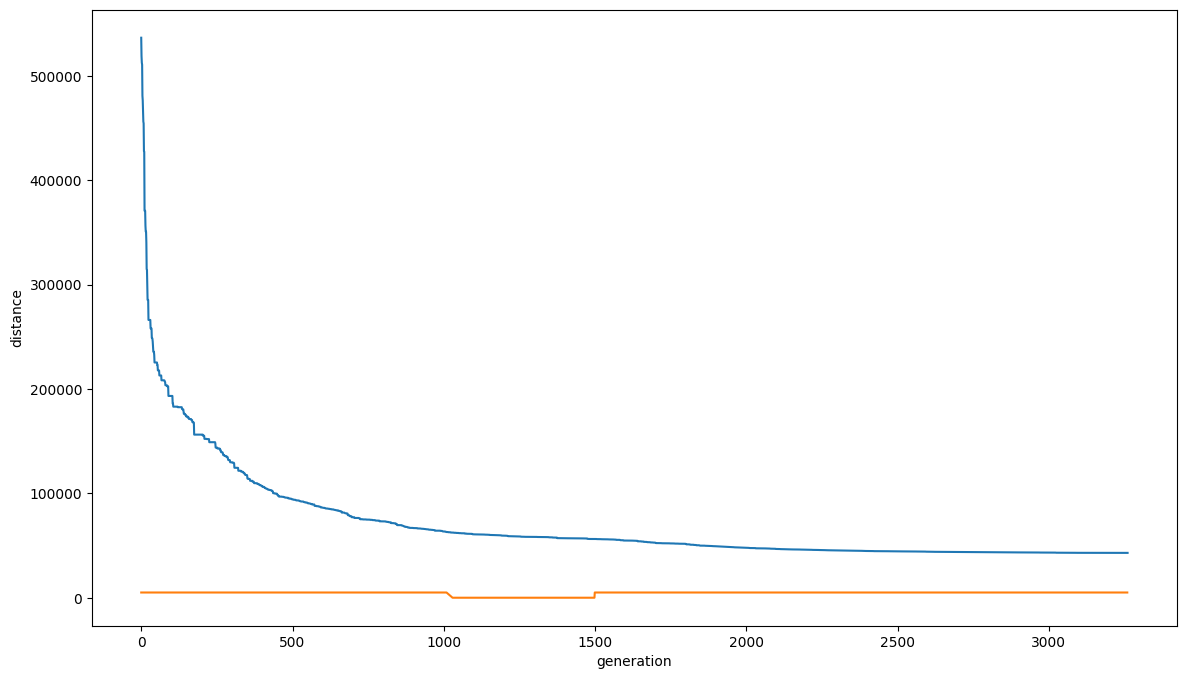

In [14]:

start_individual = Individual(greedy_solution)
population = [start_individual if i==0 else MOP.mutate(start_individual,strength_perc=70) for i in range(POPULATION_SIZE)] # start from greedy solution

ic(population[10].fitness())
history = [-population[0].fitness()]
speed_history = list()
giveup_improvement=False

def check_improvement(this_gen):
    global population
    global last_improvement_gen
    global last_max_fitness
    global SPEED
    global SPEED_DEC
    global SPEED_INC
    global delta_min_improvement
    global MAX_GENERATIONS
    global giveup_improvement

    current_mf = max([i.fitness() for i in population])
    if last_improvement_gen is None:
        # set initial values
        last_improvement_gen = this_gen
    elif abs((current_mf-last_max_fitness)/last_max_fitness)>delta_min_improvement:
        # if the algorithm work, tend to full speed (SPEED=1)
        delta_min_improvement=0.01
        new_SPEED = SPEED+SPEED_INC
        SPEED = min(new_SPEED,1)
        last_improvement_gen = this_gen
    elif this_gen-last_improvement_gen>MAX_GENERATIONS/20: # escape from local maximum!
        delta_min_improvement=0.02
        if this_gen-last_improvement_gen>MAX_GENERATIONS/5: # give up
            SPEED=1
            giveup_improvement=True
        else:
            # IF THERE ARE NO IMPROVEMENTS: increase exploration, slowing down the algorithm
            new_SPEED = SPEED-SPEED_DEC
            SPEED = max(new_SPEED,0)    
    last_max_fitness = current_mf
        

for g in tqdm(range(MAX_GENERATIONS),position=0,desc="Generation"):
    if not giveup_improvement:
        check_improvement(g)
    progress = (g*SPEED)/(MAX_GENERATIONS)
    MUTATION_PROBABILITY = START_MUTATION_PROBABILITY * (1-progress) + END_MUTATION_PROBABILITY * progress
    offspring = list()
    for _ in range(OFFSPRING_SIZE):
        if rng.random()<MUTATION_PROBABILITY:
            p = parent_selection(population)
            o = MOP.mutate(p,strength_perc=70*(1-progress)+1*progress)
        else:
            p1 = parent_selection(population)
            p2 = parent_selection(population)
            o = XOP.recombinate(p1, p2)
        offspring.append(o)

    # SURVIVOR SELECTION
    population.extend(offspring)
    population.sort(key=lambda i: i.fitness(), reverse=True)
    population = population[:POPULATION_SIZE]
    history.append(-population[0].fitness())
    speed_history.append(SPEED)

ic(genome_cost.calls)
ic(population[0].fitness())
ic(population[0].genome());
plt.figure(figsize=(14, 8))
plt.plot(history)
plt.xlabel("generation")
plt.ylabel("distance")
plt.plot(np.array(speed_history)*5000);

In [15]:
def hprint(*args,**kwargs):
    print('\x1b[1;30;42m' + args[0] + '\x1b[0m')

In [16]:
solution = population[0]
sg = solution.genome()
hprint(f"Chosen TSP Path (TOT. of {-solution.fitness()} km):")
for i in range(GENOME_SIZE):
    j=i+1 if i+1<GENOME_SIZE else 0
    print(f"{i}.  {cities.loc[sg[i],"name"]} ---> {cities.loc[sg[j],"name"]} ({dist_matrix[sg[i],sg[j]]} km)")

Chosen TSP Path (TOT. of 42969.96944480818 km):
0.  Vacaville ---> Fairfield (12.74785713916169 km)
1.  Fairfield ---> Vallejo (25.66500628728738 km)
2.  Vallejo ---> Richmond (19.131536159027558 km)
3.  Richmond ---> Berkeley (10.945509272170993 km)
4.  Berkeley ---> Oakland (12.543484546860862 km)
5.  Oakland ---> San Mateo (24.43581028983754 km)
6.  San Mateo ---> Daly City (20.72010650568532 km)
7.  Daly City ---> San Francisco (6.979245884511153 km)
8.  San Francisco ---> Santa Rosa (79.80883015980554 km)
9.  Santa Rosa ---> Chico (164.28075289869705 km)
10.  Chico ---> Sparks (182.39187825750594 km)
11.  Sparks ---> Reno (12.116385062011048 km)
12.  Reno ---> Modesto (227.36209807943828 km)
13.  Modesto ---> Fresno (144.01240240991197 km)
14.  Fresno ---> Clovis (10.907022194257276 km)
15.  Clovis ---> Visalia (64.47831895171387 km)
16.  Visalia ---> Las Vegas (364.8610169800266 km)
17.  Las Vegas ---> North Las Vegas (16.862539039483178 km)
18.  North Las Vegas ---> Sunrise Mano